This notebook analyzes data from a fasting app that allows users to log their fasts and report their experiences. The notebook is split into three main sections:

1. Exploring variables that influence the fasting experience to generate a positive result.
2. Insights related to user engagement with the app. Clustering users by engagement rate.
3. Building a supervised model to predict the fasting experience (positive or negative) and evaluation of the model.

Please see the readme for explanations of the different variables.

In [2]:
# import necessary packages
import pandas as pd
import numpy as np
import pandas_profiling
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from ast import literal_eval
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.base import clone

import warnings
warnings.filterwarnings("ignore", category = FutureWarning)

In [33]:
# read in data 
users = pd.read_csv('data/fasting_app_users.csv')
log = pd.read_csv('data/fasting_log.csv')

# Exploratory Data Analysis

In [34]:
# look at user data
print('Shape of the data is:', users.shape)
users.head()

Shape of the data is: (85068, 6)


id type_of_fast reason_for_fasting fasting_notification  age  gender
0   0        14_hr      manage_weight                  NaN   22    male
1   1        17_hr      manage_weight                21:30   28    male
2   2         8_hr     medical_advice                  NaN   44    male
3   3         9_hr    increase_energy                  NaN   39  female
4   4        18_hr        live_longer                12:30   27    male

In [35]:
# look at log data
print('Shape of the data is:', log.shape)
log.head()

Shape of the data is: (160968, 7)


user_id            timestamp  fasting_duration  hunger_level  \
0  64512.0  2017-02-09 00:00:10           59640.0          60.0   
1  47163.0  2017-02-09 00:01:25           72940.0         100.0   
2  44548.0  2017-02-09 00:01:50          112700.0          50.0   
3  52175.0  2017-02-09 00:02:02           54880.0          75.0   
4  71752.0  2017-02-09 00:02:34           78680.0          90.0   

  last_meal_content                                      motivations  \
0           protein                     ['other', 'social', 'other']   
1     carbohydrates  ['fit_in', 'weight_lifting', 'health', 'other']   
2          balanced                     ['weight_lifting', 'health']   
3           protein                                               []   
4              fats                                        ['other']   

  fasting_experience  
0           Positive  
1                NaN  
2           Negative  
3           Negative  
4                NaN

I will use the pandas profiling tool to get a better sense of the data, evaluate missing/abnormal values, and look at some distributions. I will pull out any useful/interesting information into seperate plots. This gives me a quick but deep glance into the data. 

In [6]:
# pandas profiling is an awesome EDA tool 
pandas_profiling.ProfileReport(users)

In [7]:
# again, pandas profiling to get a better sense of the data
pandas_profiling.ProfileReport(log)

# Data Cleaning and Feature Engineering

Not reporting an a reason for fasting may be important overall (e.g., putting little effort into the app, or perhaps feeling shame towards the reason). Here I will add a level as missing, rather than dropping the NAs. There are other approaches I can consider, but I will keep it simple for now.

In [36]:
# fill in missing data indicating that the data is missing with a category
users['reason_for_fasting'] = np.where(users.reason_for_fasting.isnull(),'missing', users.reason_for_fasting)

I have decided to create a feature for fasting notification being on (1) or off (0). This feature can be used to cluster data as it lends to the app engagement rate. It also may be important for positive outcomes. Need to figure out if users who set a fasting notification are more active.

In [37]:
# rename column name for clarity
users.rename(columns = {"fasting_notification": "fasting_notification_time"},inplace=True)

# assign a binary indicator to indicate if a fasting notification was set
users["fasting_notification?"] = np.where(users.fasting_notification_time.notnull(), 1,0)

I am creating an indicator column for whether the fasting_type was recorded. Again, this may be important for assessing a user’s engagement with the fasting app.

In [38]:
# assign a binary indicator to indicate if fasting type was recorded
users["indicate_fast_type?"] = np.where(users.type_of_fast.notnull(),1,0)

Because there is a great deal of variation in what motivations are reported for each user, I am going to engineer the number of motivations reported for each fasting log.

In [39]:
# function to get counts of a column
def getCounts(df_column,new_col_name):
    import warnings
    warnings.simplefilter('ignore')
    counts = []
    for row in df_column:
        row = literal_eval(row)
        counts.append(len(row))
    log[new_col_name] = counts

In [40]:
getCounts(log.motivations,"motivation_counts")

In [41]:
# check it worked
log.head(3)

user_id            timestamp  fasting_duration  hunger_level  \
0  64512.0  2017-02-09 00:00:10           59640.0          60.0   
1  47163.0  2017-02-09 00:01:25           72940.0         100.0   
2  44548.0  2017-02-09 00:01:50          112700.0          50.0   

  last_meal_content                                      motivations  \
0           protein                     ['other', 'social', 'other']   
1     carbohydrates  ['fit_in', 'weight_lifting', 'health', 'other']   
2          balanced                     ['weight_lifting', 'health']   

  fasting_experience  motivation_counts  
0           Positive                  3  
1                NaN                  4  
2           Negative                  2

26% of the data are missing responses. I will keep this in mind to come back to the possibility of modeling this as well, but for now I will focus on the positive and negative class. So I will drop the nans rows moving forward.

In [42]:
# drop null values for fasting experience
log = log[log.fasting_experience.notnull()]

Now I need to engineer features that captures the engagement level of each user. I need to keep in mind that each user has started using the app at a unique time, so the engagement level needs to be normalized by the time spent with the app. So here I will define engagement level by number of logs/total days on app to get the rate of logs per day.

In [43]:
# convert to datetime
log["timestamp"] = pd.to_datetime(log.timestamp)

In [44]:
# drop user ids that are null
log = log[log.user_id.notnull()]

# fix user id type
log["user_id"] = log.user_id.astype(int)

In [45]:
import math

# get first day for each user
user_min = log.groupby("user_id")["timestamp"].min().reset_index()
user_min.rename(columns = {"timestamp": "first_day"},inplace=True)

# get last day for each user
user_max = log.groupby("user_id")["timestamp"].max().reset_index()
user_max.rename(columns = {"timestamp": "last_day"},inplace=True)

# get number of days for each user
start_end_times = pd.merge(user_min, user_max, on="user_id")
start_end_times["days"] = round((start_end_times.last_day-start_end_times.first_day)/ np.timedelta64(1, 'D'))

# fix 0 days - change to 1 day
start_end_times["days"] = np.where(start_end_times.days == 0, 1, start_end_times.days)

# round up for each day (1.3 days = 2 days)
start_end_times["days"] = [math.ceil(day) for day in start_end_times.days]

# get median fast duration for each user
user_dur = log.groupby("user_id")["fasting_duration"].median().reset_index()
user_dur.rename(columns = {"fasting_duration": "avg_fast_length"},inplace=True)
start_end_times = pd.merge(start_end_times, user_dur, on="user_id")

start_end_times.head()

user_id           first_day            last_day  days  avg_fast_length
0        1 2017-02-20 16:08:01 2017-02-20 16:08:01     1          37800.0
1        2 2017-04-09 02:00:34 2017-04-09 02:00:34     1          94080.0
2        3 2017-03-12 04:54:59 2017-03-19 04:00:18     7          95480.0
3        4 2017-03-06 14:06:40 2017-04-19 04:24:23    44          74200.0
4        5 2017-04-01 03:03:02 2017-04-01 03:03:02     1         100240.0

I will calculate logs per day and average time between fasts.

In [46]:
# get fast count for each user
user_ct = log.groupby("user_id")["timestamp"].count().reset_index()
user_ct.rename(columns = {"timestamp": "fast_count"},inplace=True)

# merge with dataframe containing number of days
final = pd.merge(start_end_times,user_ct,on="user_id")

# calculate fasting log rate (i.e., ratio of fast logs to days with app)
final["fast_logs_per_day"] = round(final.fast_count/final.days,2)

# calculate average time between convos 
final["avg_time_btwn_fasts"] = round(final.days/final.fast_count,2)

# change the infs to 0s
from numpy import inf
final["fast_logs_per_day"] = [0 if num == inf else num for num in final.fast_logs_per_day]
final["avg_time_btwn_fasts"] = [0 if num == inf else num for num in final.avg_time_btwn_fasts]

final.head()

user_id           first_day            last_day  days  avg_fast_length  \
0        1 2017-02-20 16:08:01 2017-02-20 16:08:01     1          37800.0   
1        2 2017-04-09 02:00:34 2017-04-09 02:00:34     1          94080.0   
2        3 2017-03-12 04:54:59 2017-03-19 04:00:18     7          95480.0   
3        4 2017-03-06 14:06:40 2017-04-19 04:24:23    44          74200.0   
4        5 2017-04-01 03:03:02 2017-04-01 03:03:02     1         100240.0   

   fast_count  fast_logs_per_day  avg_time_btwn_fasts  
0           1               1.00                 1.00  
1           1               1.00                 1.00  
2           5               0.71                 1.40  
3           3               0.07                14.67  
4           1               1.00                 1.00

In [47]:
users = pd.merge(users,final, left_on="id", right_on="user_id")
users.head(3)

id type_of_fast reason_for_fasting fasting_notification_time  age  gender  \
0   1        17_hr      manage_weight                     21:30   28    male   
1   2         8_hr     medical_advice                       NaN   44    male   
2   3         9_hr    increase_energy                       NaN   39  female   

   fasting_notification?  indicate_fast_type?  user_id           first_day  \
0                      1                    1        1 2017-02-20 16:08:01   
1                      0                    1        2 2017-04-09 02:00:34   
2                      0                    1        3 2017-03-12 04:54:59   

             last_day  days  avg_fast_length  fast_count  fast_logs_per_day  \
0 2017-02-20 16:08:01     1          37800.0           1               1.00   
1 2017-04-09 02:00:34     1          94080.0           1               1.00   
2 2017-03-19 04:00:18     7          95480.0           5               0.71   

   avg_time_btwn_fasts  
0                  1.0  
1                  1.0  
2                  1.4

I am seeing some abnormal values for fasting duration, including a negative number and values with extremely long durations. For the sake of this analysis, I’m calling everything with a duration over 7 days as an outlier and will remove them. Before I remove them, I need to ensure that these outliers are randomly distributed for positive and negative outcome or else I will introduce bias.

In [48]:
print('Median fasting duration BEFORE removing outliers')
print(log.groupby('fasting_experience').fasting_duration.median())

# remove the negative value 
log = log[log.fasting_duration > 0]

# remove rows where fasting duration is less than or equal to 7 days
log = log[log.fasting_duration <= 604800] # this is 7 days in seconds
print('Median fasting duration AFTER removing outliers')
print(log.groupby('fasting_experience').fasting_duration.median())

Median fasting duration BEFORE removing outliers
fasting_experience
Negative     80780.0
Positive    111860.0
Name: fasting_duration, dtype: float64
Median fasting duration AFTER removing outliers
fasting_experience
Negative     79520.0
Positive    109760.0
Name: fasting_duration, dtype: float64


Great! Looking at these results, I can feel confident I am not introducing bias by dropping the rows. If these results were harder to interpret, I could perform a statistical test on the medians to be sure. 

I am going to bin the ages to make visualizations easier.

In [49]:
# bin the age variable for visualization
users['age_bins'] = np.where((users.age >= 18) & (users.age <= 25), '18to25', users.age)
users['age_bins'] = np.where((users.age >= 26) & (users.age <= 35), '26to35', users.age_bins)
users['age_bins'] = np.where((users.age >= 36) & (users.age <= 45), '36to45', users.age_bins)
users['age_bins'] = np.where((users.age >= 46) & (users.age <= 55), '46to55', users.age_bins)
users['age_bins'] = np.where((users.age >= 56) & (users.age <= 65), '56to65', users.age_bins)
users['age_bins'] = np.where((users.age >= 66) & (users.age <= 75), '66to75', users.age_bins)
users['age_bins'] = np.where((users.age >= 76) & (users.age <= 85), '76to85', users.age_bins)

Lastly, I want to turn seconds into hours for the fasting duration. This will be nicer for visualizations.

In [50]:
log.fasting_duration = log.fasting_duration/3600

In [51]:
log.head(3)

user_id           timestamp  fasting_duration  hunger_level  \
0    64512 2017-02-09 00:00:10         16.566667          60.0   
2    44548 2017-02-09 00:01:50         31.305556          50.0   
3    52175 2017-02-09 00:02:02         15.244444          75.0   

  last_meal_content                   motivations fasting_experience  \
0           protein  ['other', 'social', 'other']           Positive   
2          balanced  ['weight_lifting', 'health']           Negative   
3           protein                            []           Negative   

   motivation_counts  
0                  3  
2                  2  
3                  0

## Visualizations

We can see from the profile reports age is, unsurprisingly, a left-skewed distribution. The mean is 27.6 and the range is 18-85.

In [52]:
# merge the data
users_log = pd.merge(users, log, on='user_id')

In [54]:
# helper function for histogram plotting
def helperHist(column_):
    # split the data by fasting experience
    exp_pos = users_log[users_log.fasting_experience == 'Positive']
    exp_neg = users_log[users_log.fasting_experience == 'Negative']
    plt.figure(figsize = (8,4))
    sns.distplot(exp_pos[column_], bins=20, kde=False, color='magenta')
    sns.distplot(exp_neg[column_], bins=20, kde=False, color='green')
    plt.title('Distribution of {} for each class'.format(column_), fontsize = 16)
    plt.xlabel(column_,labelpad=20)
    plt.box(False)
    plt.legend(labels=['Positive','Negative']);

The median age is 25.0


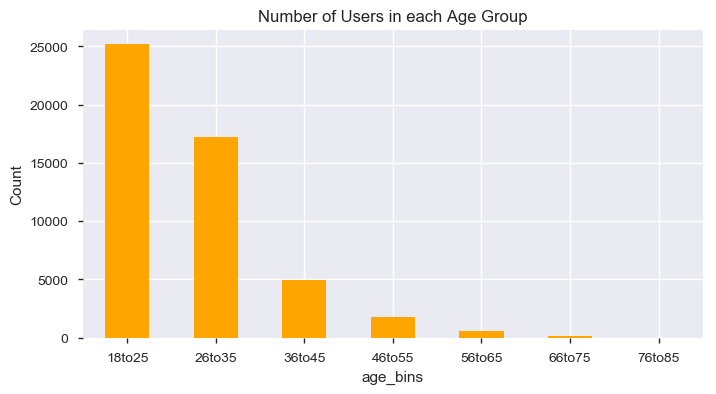

In [68]:
print('The median age is', users.age.median())
users_log.groupby('age_bins').user_id.nunique().plot(kind='bar',figsize=(8,4),color='orange')
plt.xticks(rotation=360)
plt.title('Number of Users in each Age Group')
plt.ylabel('Count');

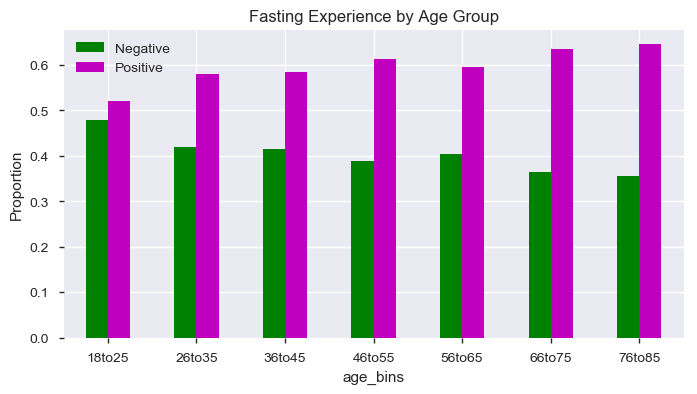

In [59]:
users_log.groupby('age_bins').fasting_experience.value_counts(normalize=True).unstack().plot(kind='bar',figsize=(8,4),
                                                                                               color=['g', 'm'])
plt.xticks(rotation=360)
plt.title('Fasting Experience by Age Group')
plt.legend(loc='upperleft')
plt.ylabel('Proportion');

The older you are, the more likely you are to rate the fasting experience as positive.

Text(0,0.5,'Hunger Level')

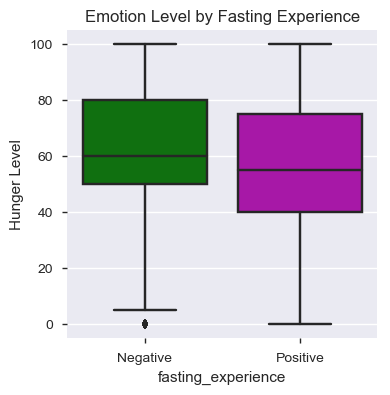

In [65]:
plt.figure(figsize=(4,4))
sns.boxplot(x="fasting_experience", y="hunger_level",
            palette=["g", "m"],
            data=users_log);
plt.title('Emotion Level by Fasting Experience')
plt.ylabel('Hunger Level')

Lower hunger levels are associated with a positive faster experience.

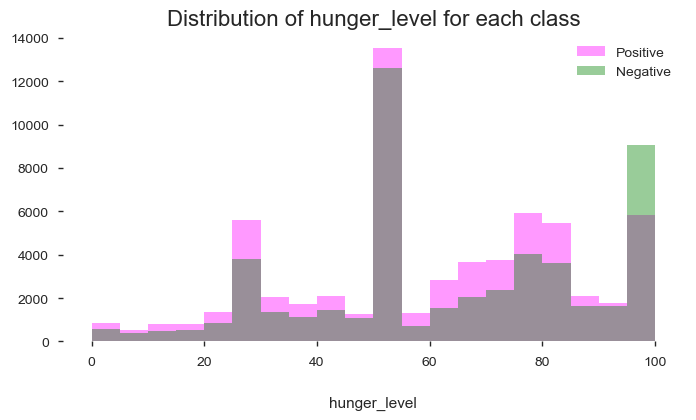

In [66]:
helperHist('hunger_level')

Super interesting! There are more positive experiences overall, which also shows here. But, the only place where negative experiences overwhelm positive ones is when the level of hunger is rated extremely high. This will be important for the model. Very insightful!

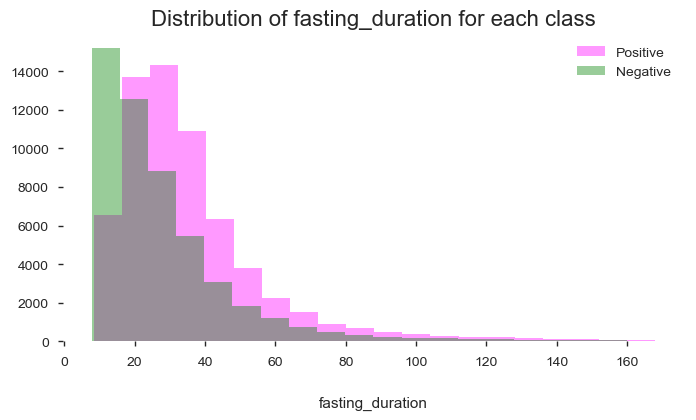

In [69]:
helperHist('fasting_duration')

Negative experiences are associated with shorter fasts. Positive experiences are associated with longer fasts. This might have something to do with the satisfaction of meeting longer fasting goals.

34% of users have fasting notifications on. Some times more common than others: 20:00, 21:00, 22:00. I will ignore the fact that I do not have timezone/location information for the sake of this analysis. Normally, I could use location or a timezone timestamp to ensure the times are representative. Is having fasting notifications turned on associated with a particular experience?

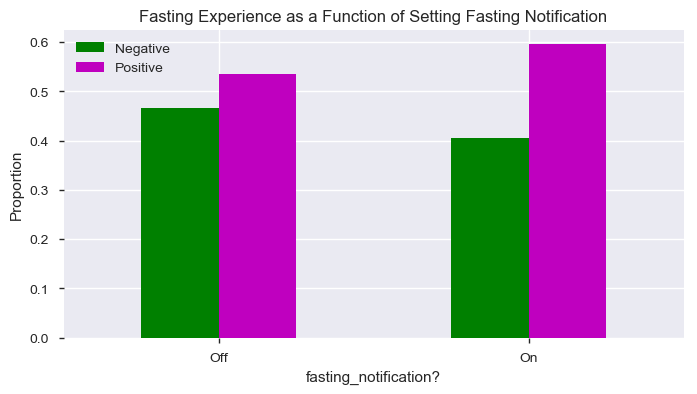

In [70]:
users_log.groupby('fasting_notification?').fasting_experience.value_counts(normalize=True).unstack().plot(kind='bar',figsize=(8,4),
                                                                                               color=['g', 'm'])
plt.xticks(np.arange(2),('Off','On'),rotation=360)
plt.title('Fasting Experience as a Function of Setting Fasting Notification')
plt.legend(loc='upperleft')
plt.ylabel('Proportion');

This is a cool effect! It looks like users with a fasting notification set tend to rate experiences more often as positive. But, only 34% of users have fasting notifications on. Find ways to increase this...

In [71]:
print('Percentage of people with fasting notifications is:', 
     round(sum(users.fasting_notification_time.notnull())/len(users.fasting_notification_time)*100,2))

Percentage of people with fasting notifications is: 34.54


Let’s see the reasons people are using this app.

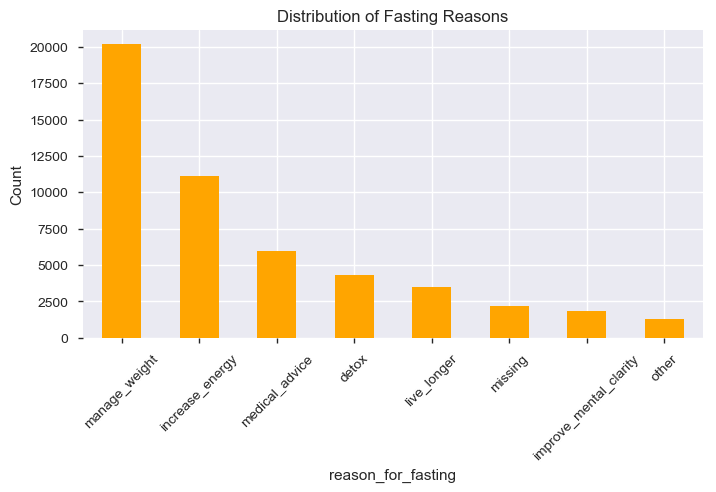

In [74]:
users.groupby('reason_for_fasting').user_id.count().sort_values(ascending=False).plot(kind='bar',figsize=(8,4),color='orange')
plt.xticks(rotation=45)
plt.title('Distribution of Fasting Reasons')
plt.ylabel('Count');

Most people use this app to manage weight, followed by a desire to increase the energy levels.  Not reporting a reason may be important overall (e.g., putting little effort into the app, or perhaps feeling shame towards reason), so I filled in these missing values above, rather than dropping them (in feature engineering section).

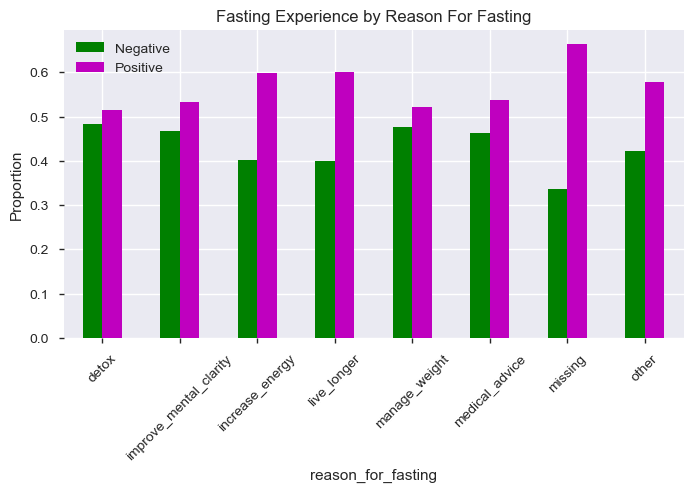

In [77]:
users_log.groupby('reason_for_fasting').fasting_experience.value_counts(normalize=True).unstack().plot(kind='bar',figsize=(8,4),
                                                                                               color=['g', 'm'])
plt.xticks(rotation=45)
plt.title('Fasting Experience by Reason For Fasting')
plt.legend(loc=0)
plt.ylabel('Proportion');

Reasons for fasting such as detox, improving mental clarity, managing weight, and following medival advice are all nearly equally likely to have a positive or negative experience. Other reasons are much more likely to have a positive experience. 

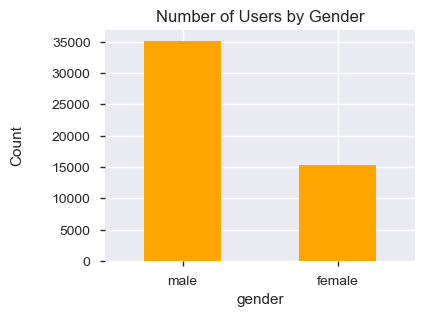

In [78]:
users.groupby('gender').user_id.count().sort_values(ascending=False).plot(kind='bar',figsize=(4,3),color='orange')
plt.xticks(rotation=0)
plt.title('Number of Users by Gender')
plt.ylabel('Count',labelpad=20);

Interestingly, the users of this app are mostly male, by more than double the amount of females! This is very cool and surprising.

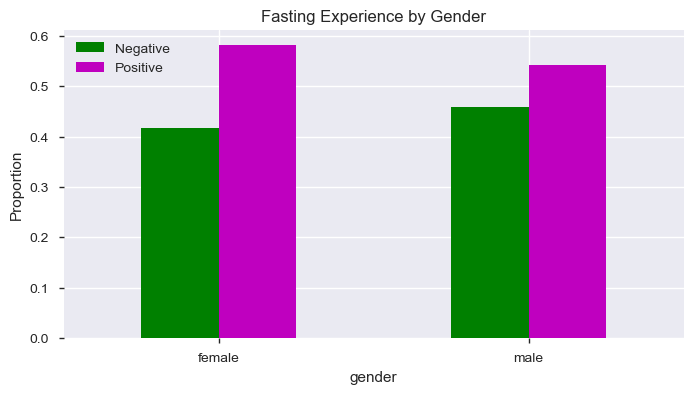

In [80]:
users_log.groupby('gender').fasting_experience.value_counts(normalize=True).unstack().plot(kind='bar',figsize=(8,4),
                                                                                               color=['g', 'm'])
plt.xticks(rotation=0)
plt.title('Fasting Experience by Gender')
plt.legend(loc='upperleft')
plt.ylabel('Proportion');

Females are slightly more likely to have a positive experience than males.

There is a lot of variation in the types of fasts people are on and not everyone has indicated which they are on (perhaps they are trying different kinds). 11% of data are missing for this category. Do users that have taken indicated a fasting regimen engage with the app more? 

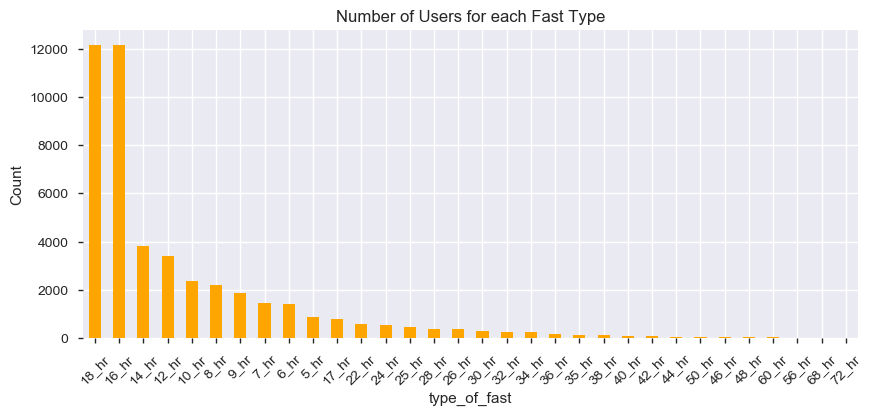

In [86]:
users.groupby('type_of_fast').user_id.count().sort_values(ascending=False).plot(kind='bar',figsize=(10,4),color='orange')
plt.xticks(rotation=45)
plt.title('Number of Users for each Fast Type')
plt.ylabel('Count');

18 and 16 hour fasts are by far the most common.

In [87]:
# this loop extracts the top 12 fasting types 
temp = users.groupby('type_of_fast').user_id.count().sort_values(ascending=False).reset_index()
idx = 0
top_num = []
while idx < 12:
    feature = temp.type_of_fast[idx]
    top_num.append(feature)
    idx = idx + 1
    
temp = users_log[users_log.type_of_fast.isin(top_num)]

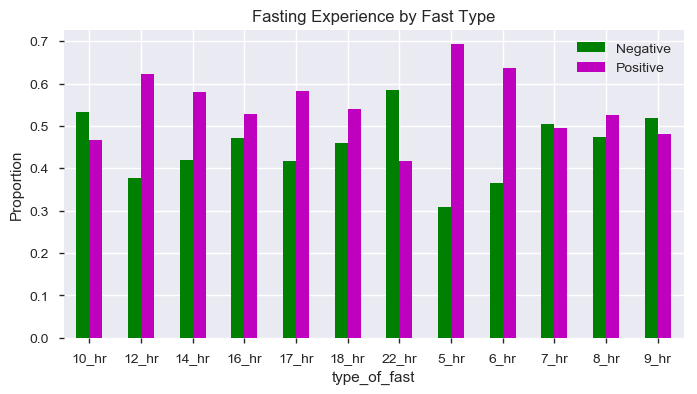

In [89]:
temp.groupby('type_of_fast').fasting_experience.value_counts(normalize=True).sort_values(ascending=False).unstack().plot(kind='bar',figsize=(8,4),
                                                                                               color=['g', 'm'])
plt.xticks(rotation=360)
plt.title('Fasting Experience by Fast Type')
plt.legend(loc='upperleft')
plt.ylabel('Proportion');

Long fasts, e.g. 22 hours, is a associated with an increase in negative experiences. But moderately long fasts (e.g., 12-18 hours), show the opposite. 

In the feature engineering section, I created a feature for the count of the number of motivating factors a user identified as contributing to their fast. Now, let’s see how the count is associated with fasting experience.

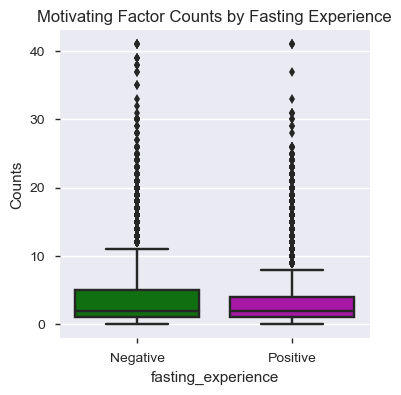

In [90]:
plt.figure(figsize=(4,4))
sns.boxplot(x="fasting_experience", y="motivation_counts",
            palette=["g", "m"],
            data=users_log);
plt.title('Motivating Factor Counts by Fasting Experience')
plt.ylabel('Counts');

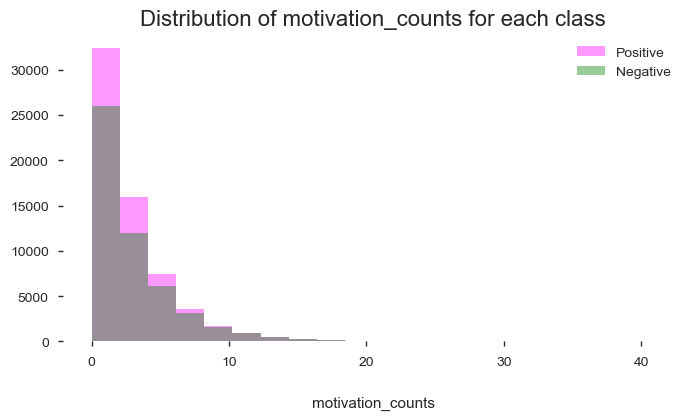

In [91]:
helperHist('motivation_counts')

The median is about the same, but the distribution is smaller for positive experiences.

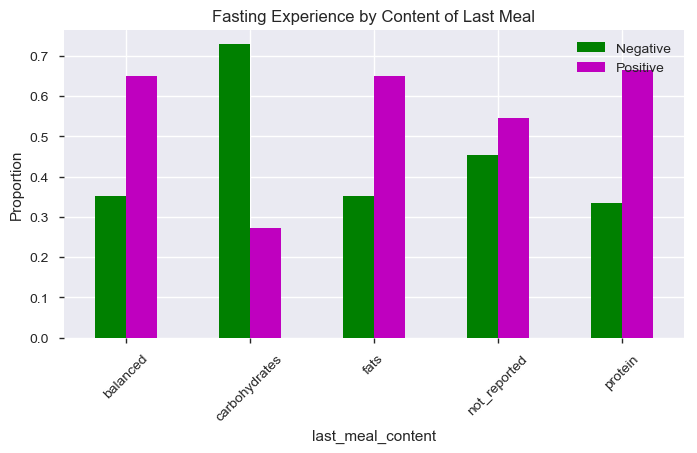

In [92]:
users_log.groupby('last_meal_content').fasting_experience.value_counts(normalize=True).sort_values(ascending=False).unstack().plot(kind='bar',figsize=(8,4),
                                                                                               color=['g', 'm'])
plt.xticks(rotation=45)
plt.title('Fasting Experience by Content of Last Meal')
plt.legend(loc='upperleft')
plt.ylabel('Proportion');

Wow, this is quite striking. When carbs are the primary source of the last meal, this is associated with an increase in the chance of having a negative experience.

Now we have to check to see the balance of our classes for the outcome. The classes should be relatively balanced. If they are not, we can take appropriate action and oversample the minority class, undersample the majority class, or use the SMOTE algorithm to create synthetic data.

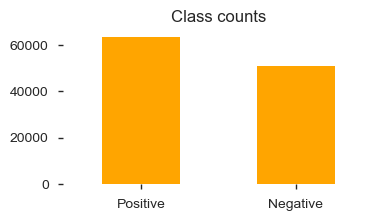

In [93]:
log.fasting_experience.value_counts(dropna=False).plot(kind='bar',figsize=(4,2),color='orange')
plt.xticks(rotation=0)
plt.box(False)
plt.title('Class counts');

They are relatively balanced so I will not do anything to them for now.

## Cluster Model

Okay, so now I have a pretty solid understanding of the data I’m working with and I’ve engineered the features that I believe will be important for modeling. I’m going to first build a clustering model to distinguish between different levels of user engagement. I chose 5 features to capture user engagement. <br> For each user, I calculated: <br>

1. Average time between fasts logs (avg_time_btwn_fasts)
2. Number of fasts per day (fasts_per_day)
3. Total fast count (fast_count)
4. Total days on app (days)
5. Median fast length (avg_fast_length)

In [130]:
# cluster users by engagement levels
users_log.avg_fast_length = users_log.avg_fast_length/3600
cols = ["avg_time_btwn_fasts", "fast_logs_per_day", "days", "fast_count","avg_fast_length"]
X = users_log[cols]
X.head(3)

avg_time_btwn_fasts  fast_logs_per_day  days  fast_count  avg_fast_length
0                  1.0               1.00     1           1        10.500000
1                  1.0               1.00     1           1        26.133333
2                  1.4               0.71     7           5        26.522222

In [98]:
sum_of_squared_distances = []
K = range(1,8)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    sum_of_squared_distances.append(km.inertia_)

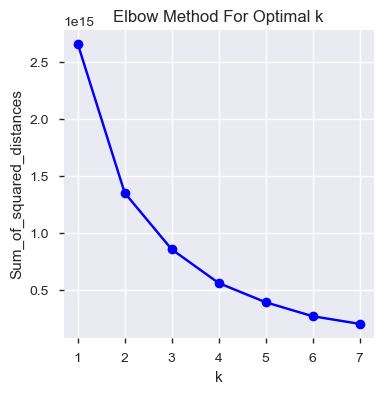

In [99]:
plt.figure(figsize=(4,4))
plt.plot(K, sum_of_squared_distances, 'bx-', marker='o')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Optimal K according to the elbow plot is 4. This is a good number in terms of business application as well.

In [125]:
def cluster(X,k):
    
    ### function for k-means ###
    
    from sklearn.preprocessing import StandardScaler

    # standardize data
    X = StandardScaler().fit_transform(X)

    # create kmeans object
    kmeans = KMeans(n_clusters=k,random_state=42)

    # fit kmeans object to data
    kmeans.fit(X)

    # save new clusters for chart
    cluster_num = kmeans.fit_predict(X)

    users_log['cluster_num'] = cluster_num;

In [126]:
cluster(X,4)

In [111]:
def plotClusters(x,y,lim_y):
    plt.figure(figsize = (10,4))
    plt.scatter(users_log[users_log.cluster_num == 0][x], users_log[users_log.cluster_num == 0][y], s=40, c='red', alpha=0.2)
    plt.scatter(users_log[users_log.cluster_num == 1][x], users_log[users_log.cluster_num == 1][y], s=40, c='yellow',alpha=0.2)
    plt.scatter(users_log[users_log.cluster_num == 2][x], users_log[users_log.cluster_num == 2][y], s=40, c='blue',alpha=0.2)
    plt.scatter(users_log[users_log.cluster_num == 3][x], users_log[users_log.cluster_num == 3][y], s=40, c='cyan',alpha=0.2)
    plt.ylabel(y)
    plt.xlabel(x)
    plt.ylim(0,lim_y)
    plt.box(False);

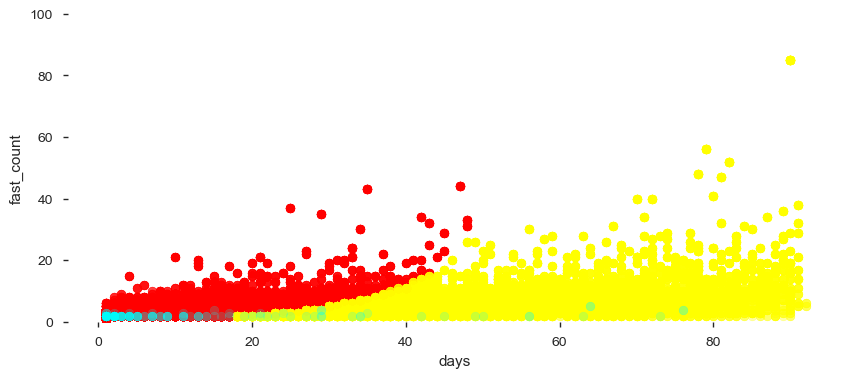

In [127]:
plotClusters('days', 'fast_count',100)

The 4th cluster is an outlier with a fast count of > 1000. It is cut out from this plot so that the other clusters can be visualized nicely. Now, let’s examine these clusters further.

In [113]:
# find the clusters characteristics
print("Red cluster size:",users_log[users_log.cluster_num == 0].shape[0])
print("Yellow cluster size:",users_log[users_log.cluster_num == 1].shape[0])
print("Blue cluster size:",users_log[users_log.cluster_num == 2].shape[0])
print("Cyan cluster size:",users_log[users_log.cluster_num == 3].shape[0])

print("")

print("Red cluster unique users:",users_log[users_log.cluster_num == 0].user_id.nunique())
print("Yellow cluster unique users:",users_log[users_log.cluster_num == 1].user_id.nunique())
print("Blue cluster unique users:",users_log[users_log.cluster_num == 2].user_id.nunique())
print("Cyan cluster unique users:",users_log[users_log.cluster_num == 3].user_id.nunique())

Red cluster size: 80815
Yellow cluster size: 32234
Blue cluster size: 1016
Cyan cluster size: 165

Red cluster unique users: 43191
Yellow cluster unique users: 6462
Blue cluster unique users: 1
Cyan cluster unique users: 162


Wow there is only one user in the blue cluster. That’s pretty unusual. Let’s see what makes this user’s behavior so unique.

The median fasting log rate for all users is: 0.44 , nearly 1 fast logged every 2 days.


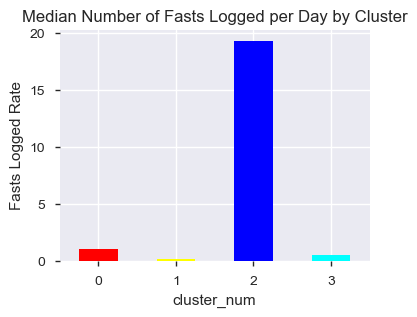

In [116]:
print('The median fasting log rate for all users is:', users_log.fast_logs_per_day.median(), ', nearly 1 fast logged every 2 days.')
plt.figure(figsize=(4,3))
users_log.groupby("cluster_num").fast_logs_per_day.median().plot(kind="bar",color=["red", "yellow","blue","cyan"]);
plt.title('Median Number of Fasts Logged per Day by Cluster')
plt.xticks(rotation=0)
plt.ylabel('Fasts Logged Rate');

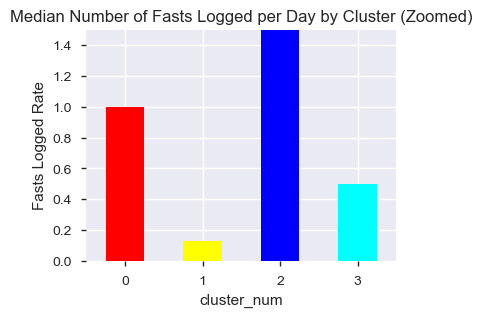

In [117]:
plt.figure(figsize=(4,3))
users_log.groupby("cluster_num").fast_logs_per_day.median().plot(kind="bar",color=["red", "yellow","blue","cyan"]);
plt.title('Median Number of Fasts Logged per Day by Cluster (Zoomed)')
plt.xticks(rotation=0)
plt.ylim(0,1.5)
plt.ylabel('Fasts Logged Rate');

Interesting. The fasts logged rate between the three clusters is quite different. Let’s see if this is associated with positive/negative experience.

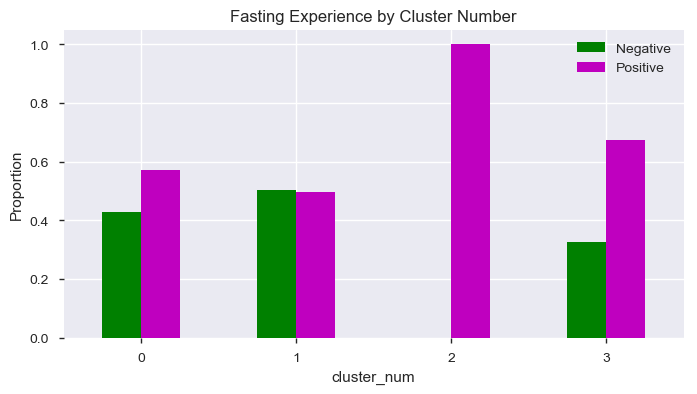

In [118]:
users_log.groupby('cluster_num').fasting_experience.value_counts(normalize=True).sort_values(ascending=False).unstack().plot(kind='bar',figsize=(8,4),
                                                                                               color=['g', 'm'])
plt.xticks(rotation=0)
plt.title('Fasting Experience by Cluster Number')
plt.legend(loc='upperleft')
plt.ylabel('Proportion');

Well, it seems like cluster number will be important in the model. Clusters 0 and 4 log fasts more often, and are more likely to rate experiences as positive. And again, Cluster 2 is anomalous and loves logging fasts. Maybe, this user should be thrown out as an outlier, but I will keep it as a first pass.

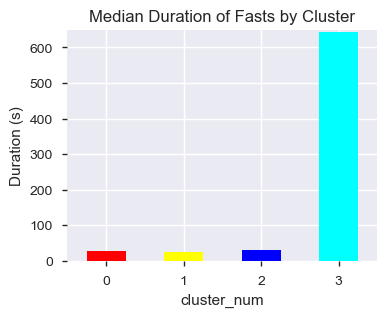

In [135]:
plt.figure(figsize=(4,3))
users_log.groupby("cluster_num").avg_fast_length.median().plot(kind="bar",color=["red", "yellow","blue","cyan"]);
plt.title('Median Duration of Fasts by Cluster')
plt.xticks(rotation=0)
plt.ylim(0,650)
plt.ylabel('Duration (s)');

Hmmm... The users in cluster 3 fast on average for nearly 650 hours. Extreme fasters?

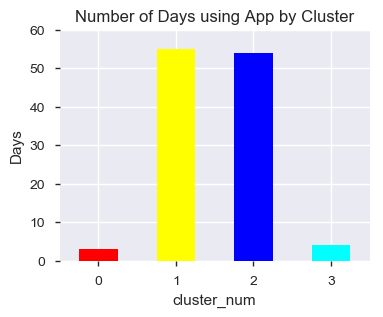

In [136]:
plt.figure(figsize=(4,3))
users_log.groupby("cluster_num").days.median().plot(kind="bar",color=["red", "yellow","blue","cyan"]);
plt.title('Number of Days using App by Cluster')
plt.xticks(rotation=0)
plt.ylim(0,60)
plt.ylabel('Days');

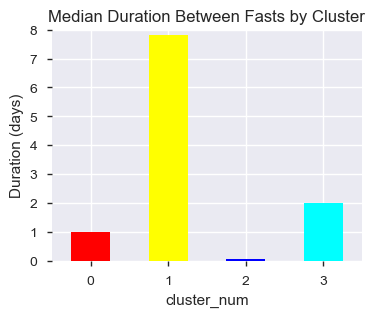

In [138]:
plt.figure(figsize=(4,3))
users_log.groupby("cluster_num").avg_time_btwn_fasts.median().plot(kind="bar",color=["red", "yellow","blue","cyan"]);
plt.title('Median Duration Between Fasts by Cluster')
plt.xticks(rotation=0)
plt.ylim(0,8)
plt.ylabel('Duration (days)');

In [139]:
print('Days between fasts by',users_log.groupby('fasting_experience').avg_time_btwn_fasts.median())

Days between fasts by fasting_experience
Negative    2.63
Positive    2.00
Name: avg_time_btwn_fasts, dtype: float64


Shorter time between fasts is associated with a higher likelihood of a positive experience.

Now, let’s look at some other aspects of the clusters such as age and gender.

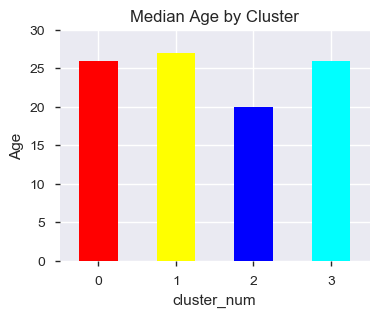

In [140]:
plt.figure(figsize=(4,3))
users_log.groupby("cluster_num").age.median().plot(kind="bar",color=["red", "yellow","blue","cyan"]);
plt.title('Median Age by Cluster')
plt.xticks(rotation=0)
plt.ylim(0,30)
plt.ylabel('Age');

Nothing really stands out here, given that cluster 3 is one user. 

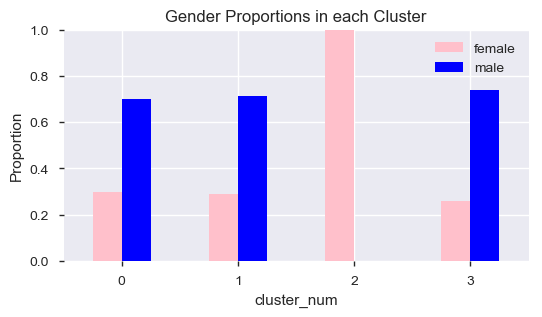

In [141]:
users_log.groupby("cluster_num").gender.value_counts(normalize=True).unstack().plot(kind="bar",color=["pink", "blue"],
                                                                                     figsize=(6,3));
plt.title('Gender Proportions in each Cluster')
plt.xticks(rotation=0)
plt.ylim(0,1)
plt.ylabel('Proportion');
plt.legend(loc='uppercenter');

Nothing really stands out here either. 

# Supervised Classification Model

Okay, it’s time to build a model. I have to consider that my samples are NOT independent. I have many samples coming from the same user, and that seriously limits what models will be acceptable for predicting conversation result (or for most importantly, generalizing to unseen data). Essentially, I can’t use a parametric approach. I have to consider non-parametric approaches that do not make assumptions about the residuals. I will try a random forest classifier to start. This is a great choice because it is non-parametric, can handle many features, usually produces good results and we can derive feature importances.

## Prepare Data

In [142]:
all_data = users_log
print(all_data.columns)
print(all_data.shape)
all_data.head(3)

Index(['id', 'type_of_fast', 'reason_for_fasting', 'fasting_notification_time',
       'age', 'gender', 'fasting_notification?', 'indicate_fast_type?',
       'user_id', 'first_day', 'last_day', 'days', 'avg_fast_length',
       'fast_count', 'fast_logs_per_day', 'avg_time_btwn_fasts', 'age_bins',
       'timestamp', 'fasting_duration', 'hunger_level', 'last_meal_content',
       'motivations', 'fasting_experience', 'motivation_counts',
       'cluster_num'],
      dtype='object')
(114230, 25)


id type_of_fast reason_for_fasting fasting_notification_time  age  gender  \
0   1        17_hr      manage_weight                     21:30   28    male   
1   2         8_hr     medical_advice                       NaN   44    male   
2   3         9_hr    increase_energy                       NaN   39  female   

   fasting_notification?  indicate_fast_type?  user_id           first_day  \
0                      1                    1        1 2017-02-20 16:08:01   
1                      0                    1        2 2017-04-09 02:00:34   
2                      0                    1        3 2017-03-12 04:54:59   

   ... avg_time_btwn_fasts  age_bins           timestamp  fasting_duration  \
0  ...                 1.0    26to35 2017-02-20 16:08:01         10.500000   
1  ...                 1.0    36to45 2017-04-09 02:00:34         26.133333   
2  ...                 1.4    36to45 2017-03-12 04:54:59         14.233333   

   hunger_level  last_meal_content  \
0          20.0      carbohydrates   
1          50.0       not_reported   
2          50.0       not_reported   

                                         motivations fasting_experience  \
0                                         ['social']           Negative   
1  ['kids', 'other', 'other', 'other', 'health', ...           Positive   
2                                                 []           Negative   

   motivation_counts  cluster_num  
0                  1            0  
1                  6            0  
2                  0            0  

[3 rows x 25 columns]

In [143]:
# change response column to binary indicator
all_data['fasting_experience'] = np.where(all_data.fasting_experience == 'Positive', 1, 0)
all_data.head(3)

id type_of_fast reason_for_fasting fasting_notification_time  age  gender  \
0   1        17_hr      manage_weight                     21:30   28    male   
1   2         8_hr     medical_advice                       NaN   44    male   
2   3         9_hr    increase_energy                       NaN   39  female   

   fasting_notification?  indicate_fast_type?  user_id           first_day  \
0                      1                    1        1 2017-02-20 16:08:01   
1                      0                    1        2 2017-04-09 02:00:34   
2                      0                    1        3 2017-03-12 04:54:59   

   ... avg_time_btwn_fasts  age_bins           timestamp  fasting_duration  \
0  ...                 1.0    26to35 2017-02-20 16:08:01         10.500000   
1  ...                 1.0    36to45 2017-04-09 02:00:34         26.133333   
2  ...                 1.4    36to45 2017-03-12 04:54:59         14.233333   

   hunger_level  last_meal_content  \
0          20.0      carbohydrates   
1          50.0       not_reported   
2          50.0       not_reported   

                                         motivations fasting_experience  \
0                                         ['social']                  0   
1  ['kids', 'other', 'other', 'other', 'health', ...                  1   
2                                                 []                  0   

   motivation_counts  cluster_num  
0                  1            0  
1                  6            0  
2                  0            0  

[3 rows x 25 columns]

In [145]:
# clean up data set - select only columns that will be modeled
cols = ['fasting_experience', 'age', 'gender', 'type_of_fast', 'reason_for_fasting', 'fasting_notification?', 'indicate_fast_type?', 'last_meal_content', 
        'fasting_duration', 'hunger_level','motivation_counts', 'cluster_num']

X_s = all_data[cols]

# one hot encode categorical variables
X_s = pd.get_dummies(X_s)

# selection response column
Y = X_s['fasting_experience']

# drop response column from features
X_s = X_s.drop(['fasting_experience'], axis='columns')

X_s.head(3)

age  fasting_notification?  indicate_fast_type?  fasting_duration  \
0   28                      1                    1         10.500000   
1   44                      0                    1         26.133333   
2   39                      0                    1         14.233333   

   hunger_level  motivation_counts  cluster_num  gender_female  gender_male  \
0          20.0                  1            0              0            1   
1          50.0                  6            0              0            1   
2          50.0                  0            0              1            0   

   type_of_fast_10_hr  ...  reason_for_fasting_live_longer  \
0                   0  ...                               0   
1                   0  ...                               0   
2                   0  ...                               0   

   reason_for_fasting_manage_weight  reason_for_fasting_medical_advice  \
0                                 1                                  0   
1                                 0                                  1   
2                                 0                                  0   

   reason_for_fasting_missing  reason_for_fasting_other  \
0                           0                         0   
1                           0                         0   
2                           0                         0   

   last_meal_content_balanced  last_meal_content_carbohydrates  \
0                           0                                1   
1                           0                                0   
2                           0                                0   

   last_meal_content_fats  last_meal_content_not_reported  \
0                       0                               0   
1                       0                               1   
2                       0                               1   

   last_meal_content_protein  
0                          0  
1                          0  
2                          0  

[3 rows x 54 columns]

In [146]:
# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_s, Y, test_size=0.2, random_state=21)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(91384, 54) (91384,)
(22846, 54) (22846,)


I want to optimize the model for precision. This is because the cost of a false positive is high. Predicting a positive experience when it is actually negative equates to missing the opportunity to intervene and possibly losing a user if they do not feel the experience was good.

In [147]:
# function for training the model
def trainRF():    
    # create classifier
    rf_model = RandomForestClassifier(n_estimators=100)

    # train the model using the training sets 
    rf_model.fit(X_train,y_train)

    # test the model 
    y_pred = rf_model.predict(X_test)

    return y_pred

In [148]:
# function for evaluating the model
def evaluate(y_test,y_pred):
    print("Accuracy:",round(metrics.accuracy_score(y_test, y_pred),3))
    print("Precision:",round(metrics.precision_score(y_test, y_pred),3))
    print("Recall:",round(metrics.recall_score(y_test, y_pred),3))
    print(pd.DataFrame(metrics.confusion_matrix(y_test, y_pred),
                       columns = ['Pred_neg', 'Pred_pos'],
                       index = ['Neg', 'Pos']))

I will start with the defaults and 100 trees.

In [150]:
y_preds = trainRF()

In [151]:
evaluate(y_test,y_preds)

Accuracy: 0.669
Precision: 0.682
Recall: 0.761
     Pred_neg  Pred_pos
Neg      5579      4523
Pos      3049      9695


68% precision is not bad!

Now let’s do a grid search to find the optimal hyperparameters.

In [153]:
# finding optimal hyperparameters for random forest model
forest_param_grid = {
    'n_estimators': [100, 500], 
    'max_features': [5, 10, 25],
    'min_samples_split': [10, 50, 100]
}

scorers = {
    'precision_score': metrics.make_scorer(metrics.precision_score),
    'recall_score': metrics.make_scorer(metrics.recall_score),
    'auc_score': metrics.make_scorer(metrics.roc_auc_score)
}

def grid_search_wrapper(refit_score = 'precision_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    print parameters of best model
    prints classifier performance metrics
    """
    rf_model_opt = RandomForestClassifier(n_jobs = -1)
    kf = KFold(n_splits = 5)
    grid_search = GridSearchCV(rf_model_opt, param_grid = forest_param_grid, scoring = scorers,
                               refit = refit_score, cv = kf, return_train_score = True)
    grid_search.fit(X_train, y_train)

    # make the predictions
    y_pred = grid_search.predict(X_test)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(metrics.confusion_matrix(y_test, y_pred),
                 columns = ['Pred_neg', 'Pred_pos'], index = ['Neg', 'Pos']))
    return grid_search

grid_search_opt = grid_search_wrapper(refit_score = 'precision_score')

Best params for precision_score
{'max_features': 5, 'min_samples_split': 10, 'n_estimators': 500}

Confusion matrix of Random Forest optimized for precision_score on the test data:
     Pred_neg  Pred_pos
Neg      5420      4682
Pos      2597     10147


In [154]:
results_clf_1 = pd.DataFrame(grid_search_opt.cv_results_)
results_clf_1 = results_clf_1.sort_values(by='mean_test_precision_score', ascending=False)
results_clf_1[['mean_test_precision_score', 'mean_test_recall_score',
               'mean_test_auc_score', 'mean_train_auc_score',
               'param_max_features', 'param_min_samples_split','param_n_estimators']].round(3).head()

mean_test_precision_score  mean_test_recall_score  mean_test_auc_score  \
1                      0.683                   0.799                0.670   
0                      0.682                   0.794                0.668   
7                      0.681                   0.801                0.668   
6                      0.681                   0.797                0.668   
3                      0.680                   0.820                0.671   

   mean_train_auc_score param_max_features param_min_samples_split  \
1                 0.870                  5                      10   
0                 0.867                  5                      10   
7                 0.895                 10                      10   
6                 0.892                 10                      10   
3                 0.722                  5                      50   

  param_n_estimators  
1                500  
0                100  
7                500  
6                100  
3                500

Well, precision is still 68%, despite optimizing for it! Recall did improve to 80%. So I will update the hyperparameters regardless because it does not hurt precision to do so. 

In [159]:
# create classifier with new hyperparameters
rf_model = RandomForestClassifier(n_estimators=500,min_samples_split=10,max_features=5,oob_score=True)

# train the model using the training sets 
rf_model.fit(X_train,y_train)

# test the model 
y_pred = rf_model.predict(X_test)

In [156]:
# evaluate the final model
evaluate(y_test,y_pred)

Accuracy: 0.68
Precision: 0.683
Recall: 0.797
     Pred_neg  Pred_pos
Neg      5382      4720
Pos      2587     10157


## Best Predictors of a Positive Experience

Now let’s take a look at the feature importances. I am not using the inherent feature importance method in sklearn because in it is not accurate. Rather, I will iteratively drop them and retrain the model to figure out the importances.

In [157]:
def dropcol_importances(rf, X_train, y_train):
    rf_ = clone(rf)
    rf_.random_state = 6059
    rf_.fit(X_train, y_train)
    baseline = rf_.oob_score_
    feat_imp = []
    for col in X_train.columns:
        X = X_train.drop(col, axis=1)
        rf_ = clone(rf)
        rf_.random_state = 6059
        rf_.fit(X, y_train)
        oob = rf_.oob_score_
        feat_imp.append(baseline - oob)
    feat_imp = np.array(feat_imp)
    imp_df = pd.DataFrame(data = {
        'Feature': X_train.columns,'Importance': feat_imp
    })
    imp_df = imp_df.set_index('Feature')
    imp_df = imp_df.sort_values('Importance', ascending=False)
    return imp_df

In [160]:
feat_impt = dropcol_importances(rf_model, X_train, y_train)

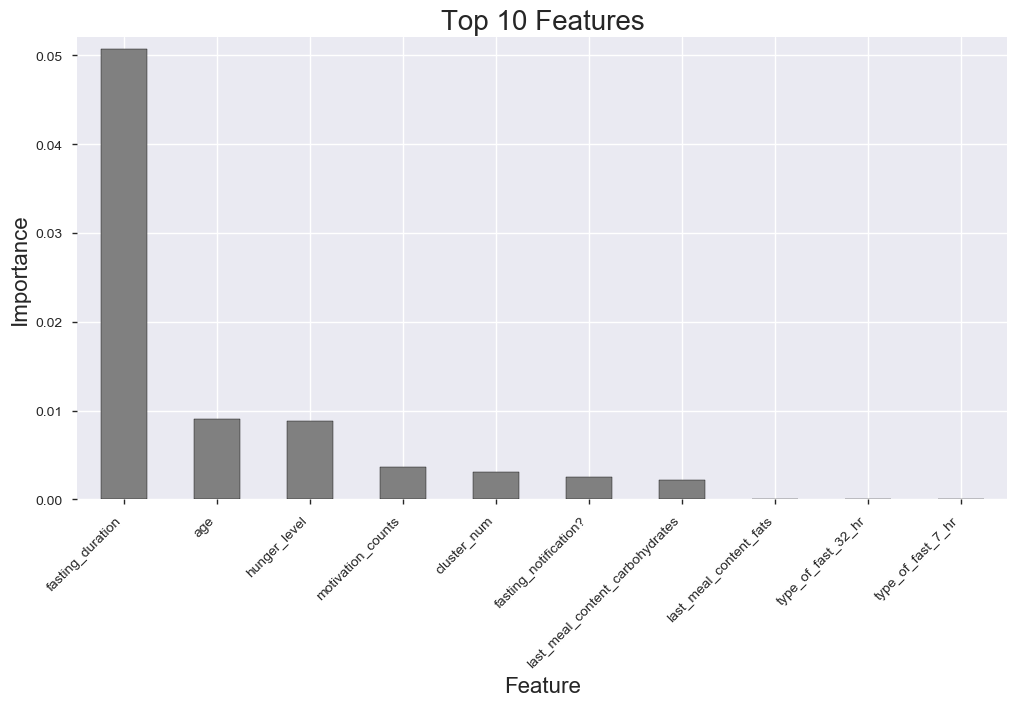

In [166]:
# plot top 10 features
feat_impt.head(10).plot(kind='bar', figsize=(12,6), color='gray', edgecolor='k', legend=None)
plt.title('Top 10 Features', fontsize=20)
plt.ylabel('Importance', fontsize=16)
plt.xlabel('Feature', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.ylim(0,0.052);